In [1]:
# Data imports and such
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# http://stat-computing.org/dataexpo/2009/the-data.html

In [2]:
airports = pd.read_excel('Data/airports new.xlt')
carriers  = pd.read_excel('Data/carriers.xls')
carriers.columns = ['UniqueCarrier','Description']

In [3]:
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


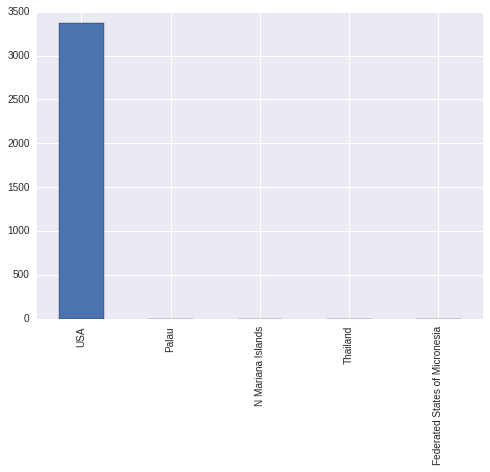

In [4]:
airports.country.value_counts().plot(kind='bar')

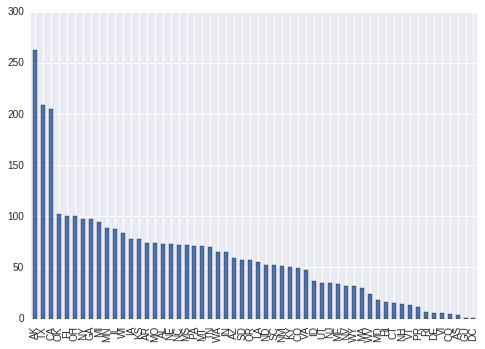

In [5]:
airports.state.value_counts().plot(kind='bar')

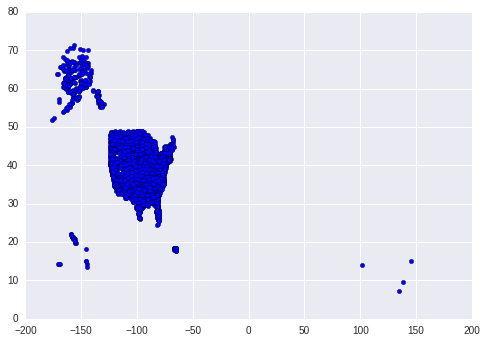

In [6]:
plt.scatter(airports.long,airports.lat)
plt.show()

In [7]:
carriers.dropna(how="all", inplace=True) 
carriers.head()
carriers.query("UniqueCarrier=='PS'")

,UniqueCarrier,Description
2055,PS,Pacific Southwest Airlines


In [8]:
trips_87 = pd.read_csv('Data/trips/1987.csv')
trips_87.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1987,10,14,3,741.0,730,912.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1987,10,15,4,729.0,730,903.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1987,10,17,6,741.0,730,918.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1987,10,18,7,729.0,730,847.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1987,10,19,1,749.0,730,922.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [9]:
trips_87[[ u'Origin', u'Dest']]

,Origin,Dest
0,SAN,SFO
1,SAN,SFO
2,SAN,SFO
3,SAN,SFO
4,SAN,SFO
5,SAN,SFO
6,SAN,SFO
7,SAN,SFO
8,SAN,SFO
9,SAN,SFO


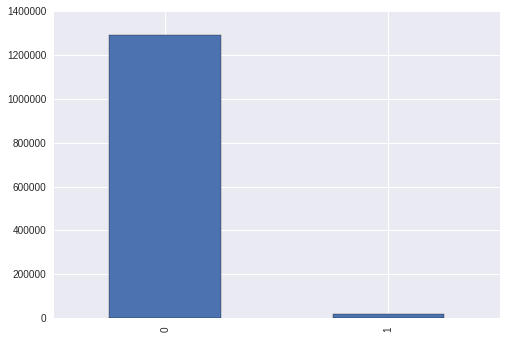

In [10]:
trips_87.Cancelled.value_counts().plot(kind='bar')

##### Potential questions:
* What are the weakest links in this network? (what can be measured in terms of network robustness?)
* Temporal trend
* What are the factors that influence weak performance (airlines, airports)?
* Are there geographical factors on bad performance?
* Can we predict delays in 2008 data based on delays on previous years?
* *STUDY MACHINE LEARNING!*

In [11]:
data = trips_87.merge(carriers,on='UniqueCarrier')
data.columns

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime',
       u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance',
       u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'Description'],
      dtype='object')

In [12]:
print(len(data))
print(len(trips_87))

1311826
1311826


In [13]:
# Data from http://www.airportcodes.us/us-airports.htm
codes = pd.read_csv('Data/airport_codes.csv')
codes = codes.set_index('Code').to_dict()

In [14]:
data["origin_city"] = data["Origin"].map(codes['City'])
data["destin_city"] = data["Dest"].map(codes['City'])

In [15]:
data.columns

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime',
       u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance',
       u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'Description', u'origin_city', u'destin_city'],
      dtype='object')

In [16]:
# Matrix, clustering?
delays = data.groupby(['origin_city','destin_city'])[['ArrDelay','DepDelay']].mean()

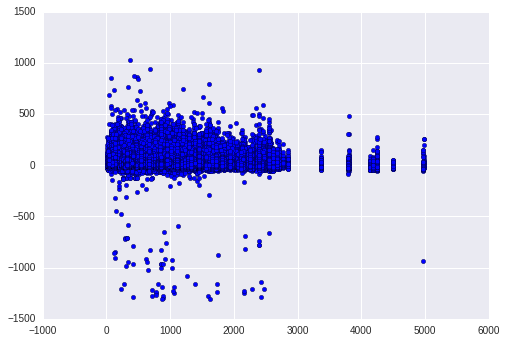

In [17]:
plt.scatter(data.Distance,data.ArrDelay)

In [18]:
airports = airports[['airport','city','lat','long']].set_index('city').to_dict()

In [19]:
data["origin_lat"] = data["origin_city"].map(airports['lat'])
data["origin_long"] = data["origin_city"].map(airports['long'])
data["destin_lat"] = data["destin_city"].map(airports['lat'])
data["destin_long"] = data["destin_city"].map(airports['long'])

In [22]:
data.iloc[0]

Year                                       1987
Month                                        10
DayofMonth                                   14
DayOfWeek                                     3
DepTime                                     741
CRSDepTime                                  730
ArrTime                                     912
CRSArrTime                                  849
UniqueCarrier                                PS
FlightNum                                  1451
TailNum                                     NaN
ActualElapsedTime                            91
CRSElapsedTime                               79
AirTime                                     NaN
ArrDelay                                     23
DepDelay                                     11
Origin                                      SAN
Dest                                        SFO
Distance                                    447
TaxiIn                                      NaN
TaxiOut                                 

In [45]:
import os
lst = []
path = 'Data/trips/'
test = pd.DataFrame([])
for name in os.listdir(path):
    df = pd.read_csv(path+name,index_col=None, header=0)
    lst.append(df)

In [46]:
trips = pd.concat(lst)